In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import random

In [12]:
def simulate_bivariate_abpnl(n: int) -> dict: 
    def f1(x: np.array) -> np.array:
        return x**(-1) + 10*x
    def f2(z: np.array) -> np.array:
        return z**3
    
    x = np.random.uniform(0.1, 1.1, n)
    noise = np.random.uniform(0, 5, n)
    
    z = f1(x) + noise
    y = f2(z)
    df = pd.DataFrame({'x1': x, 'x2': y})
    sim_data = {'df': df, 'noise': noise}
    
    return sim_data

In [13]:
def centering(M):
    n = M.shape[0]
    mat_ones = torch.ones((n, n))
    idendity = torch.eye(n)
    H = idendity - mat_ones/n
    
    C = torch.matmul(M, H)
    return C
    
    
def gaussian_grammat(x, sigma2=None):
    xxT = torch.squeeze(torch.matmul(x, x.T))
    x2 = torch.diag(xxT)
    xnorm = x2 - xxT + (x2 - xxT).T
    
    if sigma2 is None:
        sigma2 = torch.median(xnorm[xnorm != 0])
        
    if sigma2 == 0:
        sigma2 += 1e-16
        
    Kx = torch.exp(-xnorm/sigma2)
    
    return Kx
    
def HSIC(x, y):
    gram_x = gaussian_grammat(x)
    gram_y = gaussian_grammat(y)
    
    c = x.shape[0]**2
    hsic = torch.trace(torch.matmul(centering(gram_x), centering(gram_y)))/c
    
    return hsic

In [14]:
x = torch.Tensor(np.random.normal(size=1000).reshape((-1, 1, 1)))
y = torch.Tensor(np.random.normal(size=1000).reshape((-1, 1, 1)))
print(HSIC(x, y))
print(HSIC(x, x))

tensor(0.0002)
tensor(0.0999)


In [15]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        data = self.data[idx, :]
        
        return data[:-1].reshape((-1, 1)), data[-1].reshape((-1, 1))
    

class Network(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
#             nn.LeakyReLU()
        )
        
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
#             nn.LeakyReLU()
        )
        self.decode = nn.Sequential(
            nn.Linear(input_dim, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, 5),
            nn.LeakyReLU(),
            nn.Linear(5, input_dim)
#             nn.LeakyReLU()
        )
        
    def forward(self, x, y):
        g1_x = self.network(x)
        g3_y = self.encode(y)
        y_approx = self.decode(g3_y)
        
        assert y.shape == y_approx.shape
        
        return [g1_x, y_approx, g3_y]
    
def train_model(train_loader, test_loader, num_epochs, input_dim, log_every_batch = 10):
    device = 0 if torch.cuda.is_available() else 'cpu'
    model = Network(input_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))

    train_loss_avgs = []
    test_loss_avgs = []
    
    min_loss = 10000

    for epoch in range(num_epochs):
        model.train()
        train_loss_trace = []

        for batch, (x, y) in enumerate(train_loader):
            x = x.to(device)
            x = x.float()
            y = y.to(device)
            y = y.float()

            g1_x, y_approx, g3_y = model.forward(x, y)
            noise = g3_y - g1_x

            loss = lamb*F.mse_loss(y_approx, y) + (1-lamb)*HSIC(x, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_trace.append(loss.detach().item())
            if batch % log_every_batch == 0:
                print(f'Training: epoch {epoch} batch {batch} loss {loss}')

        model.eval()
        test_loss_trace = []
        for batch, (x, y) in enumerate(test_loader):
            x = x.to(device)
            x = x.float()
            y = y.to(device)
            y = y.float()

            g1_x, y_approx, g3_y = model.forward(x, y)
            noise = g3_y - g1_x

            loss = lamb*F.mse_loss(y_approx, y) + (1-lamb)*HSIC(x, noise)

            test_loss_trace.append(loss.detach().item())
            if batch % log_every_batch == 0:
                print(f'Test: epoch {epoch} batch {batch} loss {loss}')

        train_avg = np.mean(train_loss_trace)
        test_avg = np.mean(test_loss_trace)
        
        if test_avg < min_loss:
            min_loss = test_avg

        train_loss_avgs.append(train_avg)
        test_loss_avgs.append(test_avg)
        print(f'epoch {epoch} finished - avarage train loss {train_avg} ',
             f'avarage test loss {test_avg}')
        
    return train_loss_avgs, test_loss_avgs, min_loss

In [16]:
n = 1000

batch_size = 32
lamb = 0.5
num_epochs = 200

num_trials = 9

In [17]:
data = simulate_bivariate_abpnl(n)
df = data['df']
df = (df-df.mean())/df.std()
noise = data['noise']

In [18]:
def get_final_median_loss(df, num_trials):
    rand_seed = np.random.randint(0, 1000000)
    random.seed(rand_seed)
    np.random.seed(rand_seed)
    torch.manual_seed(rand_seed)

    input_dim = df.shape[1] - 1

    train, test = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)

    train = np.array(train)
    test = np.array(test)

    train = MyDataset(train)
    test = MyDataset(test)
    
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, 
                              num_workers=0, pin_memory=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False,
                             num_workers=0, pin_memory=True)
    
    losses = []
    for trial in range(num_trials):
        train_loss_avgs, test_loss_avgs, min_loss = train_model(train_loader, test_loader, 
                                                                num_epochs, input_dim)
        losses.append(min_loss)
    
    median_loss = np.median(losses)
    return median_loss, losses

In [19]:
# for b, (x, y) in enumerate(train_loader):
#     print(b)
#     print(x.shape)
#     print(y.shape)

In [ ]:
median_loss, losses = get_final_median_loss(df, num_trials)

In [ ]:
median_loss

In [ ]:
losses

In [ ]:
df[['x2', 'x1']].head()

In [ ]:
median_loss_back, losses_back = get_final_median_loss(df[['x2', 'x1']], num_trials)

In [ ]:
median_loss_back

In [ ]:
losses_back

In [22]:
input_dim = df.shape[1] - 1

train, test = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)

train = np.array(train)
test = np.array(test)

train = MyDataset(train)
test = MyDataset(test)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=True)

train_loss_avgs, test_loss_avgs, min_loss = train_model(train_loader, test_loader, num_epochs, input_dim)

Training: epoch 0 batch 0 loss 0.486777663230896
Training: epoch 0 batch 10 loss 0.3501189649105072
Training: epoch 0 batch 20 loss 0.5876509547233582
Test: epoch 0 batch 0 loss 0.5590214133262634
epoch 0 finished - avarage train loss 0.49371940719670265  avarage test loss 0.5362509563565254
Training: epoch 1 batch 0 loss 0.4460937976837158
Training: epoch 1 batch 10 loss 0.38682302832603455
Training: epoch 1 batch 20 loss 0.3121492266654968
Test: epoch 1 batch 0 loss 0.5540825724601746
epoch 1 finished - avarage train loss 0.49984868744323996  avarage test loss 0.5277683585882187
Training: epoch 2 batch 0 loss 0.724864661693573
Training: epoch 2 batch 10 loss 0.3382974863052368
Training: epoch 2 batch 20 loss 0.3382416367530823
Test: epoch 2 batch 0 loss 0.5542178153991699
epoch 2 finished - avarage train loss 0.5059924536737902  avarage test loss 0.532088577747345
Training: epoch 3 batch 0 loss 0.3458938002586365
Training: epoch 3 batch 10 loss 0.612373948097229
Training: epoch 3 bat

Training: epoch 28 batch 10 loss 0.28231051564216614
Training: epoch 28 batch 20 loss 0.33622971177101135
Test: epoch 28 batch 0 loss 0.5509820580482483
epoch 28 finished - avarage train loss 0.5177145271465696  avarage test loss 0.5346122235059738
Training: epoch 29 batch 0 loss 0.397945374250412
Training: epoch 29 batch 10 loss 0.7644727230072021
Training: epoch 29 batch 20 loss 0.347774475812912
Test: epoch 29 batch 0 loss 0.5428058505058289
epoch 29 finished - avarage train loss 0.49609759963791944  avarage test loss 0.5297684222459793
Training: epoch 30 batch 0 loss 0.5502181053161621
Training: epoch 30 batch 10 loss 0.6264488697052002
Training: epoch 30 batch 20 loss 0.33015918731689453
Test: epoch 30 batch 0 loss 0.5496797561645508
epoch 30 finished - avarage train loss 0.49891291918425723  avarage test loss 0.5280250087380409
Training: epoch 31 batch 0 loss 0.37534329295158386
Training: epoch 31 batch 10 loss 0.36118847131729126
Training: epoch 31 batch 20 loss 0.35337156057357

Test: epoch 56 batch 0 loss 0.5504302382469177
epoch 56 finished - avarage train loss 0.49823798187847795  avarage test loss 0.5266998261213303
Training: epoch 57 batch 0 loss 0.5527229309082031
Training: epoch 57 batch 10 loss 0.46343809366226196
Training: epoch 57 batch 20 loss 0.39422959089279175
Test: epoch 57 batch 0 loss 0.545792281627655
epoch 57 finished - avarage train loss 0.49342165013839456  avarage test loss 0.5266774818301201
Training: epoch 58 batch 0 loss 0.37031084299087524
Training: epoch 58 batch 10 loss 0.3464216887950897
Training: epoch 58 batch 20 loss 0.6542813181877136
Test: epoch 58 batch 0 loss 0.5481132864952087
epoch 58 finished - avarage train loss 0.4921563683912672  avarage test loss 0.5273498445749283
Training: epoch 59 batch 0 loss 0.6698369979858398
Training: epoch 59 batch 10 loss 0.4783373177051544
Training: epoch 59 batch 20 loss 0.7348088026046753
Test: epoch 59 batch 0 loss 0.5463593602180481
epoch 59 finished - avarage train loss 0.49902872176005

Test: epoch 84 batch 0 loss 0.5494433045387268
epoch 84 finished - avarage train loss 0.4992198481641967  avarage test loss 0.5321796759963036
Training: epoch 85 batch 0 loss 0.36022672057151794
Training: epoch 85 batch 10 loss 0.42218098044395447
Training: epoch 85 batch 20 loss 0.4689597189426422
Test: epoch 85 batch 0 loss 0.5459562540054321
epoch 85 finished - avarage train loss 0.49243389532483856  avarage test loss 0.5320647656917572
Training: epoch 86 batch 0 loss 0.3608652651309967
Training: epoch 86 batch 10 loss 0.3677614629268646
Training: epoch 86 batch 20 loss 0.3595360517501831
Test: epoch 86 batch 0 loss 0.5454296469688416
epoch 86 finished - avarage train loss 0.48725177810109893  avarage test loss 0.5309589356184006
Training: epoch 87 batch 0 loss 0.40882307291030884
Training: epoch 87 batch 10 loss 0.5460501909255981
Training: epoch 87 batch 20 loss 0.5087610483169556
Test: epoch 87 batch 0 loss 0.5477572083473206
epoch 87 finished - avarage train loss 0.5252222213251

Test: epoch 112 batch 0 loss 0.010983346030116081
epoch 112 finished - avarage train loss 0.016466962783757984  avarage test loss 0.019515708554536104
Training: epoch 113 batch 0 loss 0.017635397613048553
Training: epoch 113 batch 10 loss 0.012795877642929554
Training: epoch 113 batch 20 loss 0.01827070489525795
Test: epoch 113 batch 0 loss 0.011939122341573238
epoch 113 finished - avarage train loss 0.018133017684108223  avarage test loss 0.02016816451214254
Training: epoch 114 batch 0 loss 0.016588369384407997
Training: epoch 114 batch 10 loss 0.012136789970099926
Training: epoch 114 batch 20 loss 0.019241468980908394
Test: epoch 114 batch 0 loss 0.011580515652894974
epoch 114 finished - avarage train loss 0.017859401887860792  avarage test loss 0.020409259479492903
Training: epoch 115 batch 0 loss 0.013478556647896767
Training: epoch 115 batch 10 loss 0.012443812564015388
Training: epoch 115 batch 20 loss 0.01594242826104164
Test: epoch 115 batch 0 loss 0.010952277109026909
epoch 11

Test: epoch 140 batch 0 loss 0.0062117441557347775
epoch 140 finished - avarage train loss 0.009248443847072536  avarage test loss 0.012322585447691381
Training: epoch 141 batch 0 loss 0.009445441886782646
Training: epoch 141 batch 10 loss 0.006231349427253008
Training: epoch 141 batch 20 loss 0.01107251551002264
Test: epoch 141 batch 0 loss 0.006647930480539799
epoch 141 finished - avarage train loss 0.008444188283114084  avarage test loss 0.012571442406624556
Training: epoch 142 batch 0 loss 0.006005963310599327
Training: epoch 142 batch 10 loss 0.007946675643324852
Training: epoch 142 batch 20 loss 0.005053757224231958
Test: epoch 142 batch 0 loss 0.005276986863464117
epoch 142 finished - avarage train loss 0.008383578211390253  avarage test loss 0.010840787785127759
Training: epoch 143 batch 0 loss 0.010336454026401043
Training: epoch 143 batch 10 loss 0.013684984296560287
Training: epoch 143 batch 20 loss 0.005902457050979137
Test: epoch 143 batch 0 loss 0.0063509284518659115
epoc

Test: epoch 166 batch 0 loss 0.004797114059329033
epoch 166 finished - avarage train loss 0.007970017629900369  avarage test loss 0.01071532117202878
Training: epoch 167 batch 0 loss 0.008952473290264606
Training: epoch 167 batch 10 loss 0.005189978517591953
Training: epoch 167 batch 20 loss 0.008898586966097355
Test: epoch 167 batch 0 loss 0.0069859703071415424
epoch 167 finished - avarage train loss 0.0069885601867632615  avarage test loss 0.01179851545020938
Training: epoch 168 batch 0 loss 0.006576745305210352
Training: epoch 168 batch 10 loss 0.011686569079756737
Training: epoch 168 batch 20 loss 0.008993013761937618
Test: epoch 168 batch 0 loss 0.0076161460019648075
epoch 168 finished - avarage train loss 0.009783478188810164  avarage test loss 0.011979269445873797
Training: epoch 169 batch 0 loss 0.008380693383514881
Training: epoch 169 batch 10 loss 0.004872174933552742
Training: epoch 169 batch 20 loss 0.003978370223194361
Test: epoch 169 batch 0 loss 0.008232330903410912
epoc

Test: epoch 194 batch 0 loss 0.005792954936623573
epoch 194 finished - avarage train loss 0.007466499171829943  avarage test loss 0.01396740018390119
Training: epoch 195 batch 0 loss 0.005827430170029402
Training: epoch 195 batch 10 loss 0.004223673138767481
Training: epoch 195 batch 20 loss 0.013184383511543274
Test: epoch 195 batch 0 loss 0.006093240343034267
epoch 195 finished - avarage train loss 0.00770873311457449  avarage test loss 0.012927392264828086
Training: epoch 196 batch 0 loss 0.005671757273375988
Training: epoch 196 batch 10 loss 0.002690342254936695
Training: epoch 196 batch 20 loss 0.0037336964160203934
Test: epoch 196 batch 0 loss 0.0054428232833743095
epoch 196 finished - avarage train loss 0.0075990540890729635  avarage test loss 0.01302330824546516
Training: epoch 197 batch 0 loss 0.0048870607279241085
Training: epoch 197 batch 10 loss 0.010216288268566132
Training: epoch 197 batch 20 loss 0.0037414454855024815
Test: epoch 197 batch 0 loss 0.005961173214018345
epo

In [25]:
min_loss

0.010557935922406614

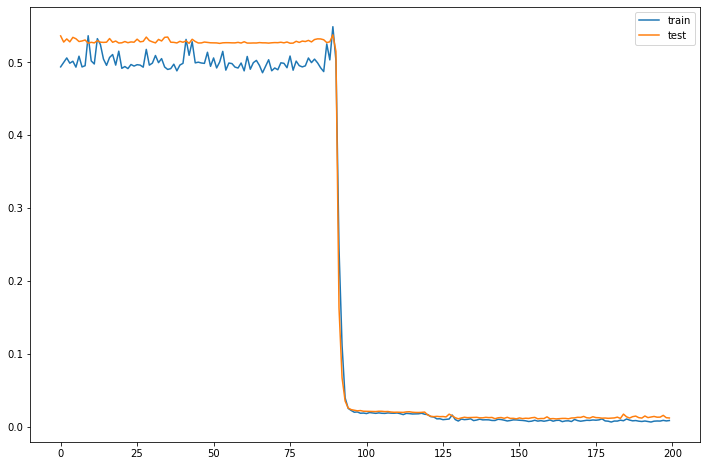

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(train_loss_avgs, label='train')
ax.plot(test_loss_avgs, label='test')
ax.legend()

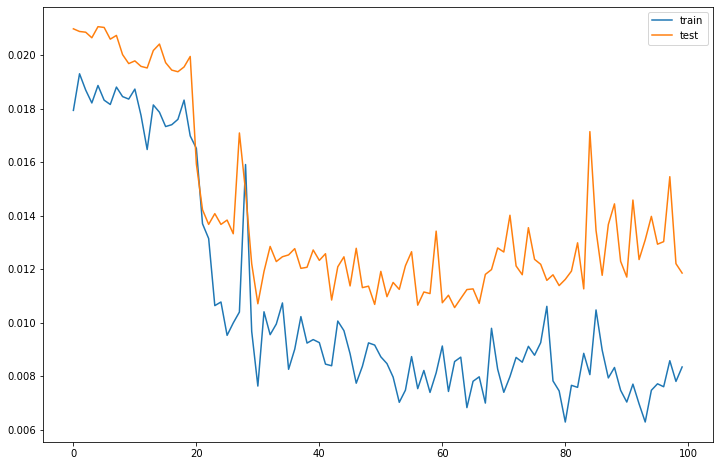

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(train_loss_avgs[100:], label='train')
ax.plot(test_loss_avgs[100:], label='test')
ax.legend()

In [ ]:
plt.savefig("ssh.png")